In [15]:
#Phase 1 — Imports & Load Data
import pandas as pd

trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [16]:
trades["Timestamp"].head(10)

0    1.730000e+12
1    1.730000e+12
2    1.730000e+12
3    1.730000e+12
4    1.730000e+12
5    1.730000e+12
6    1.730000e+12
7    1.730000e+12
8    1.730000e+12
9    1.730000e+12
Name: Timestamp, dtype: float64

In [34]:
#Phase 2 — Data Quality Check
print(trades.shape)
print(sentiment.shape)

(211224, 17)
(2644, 4)


Dataset Overview

Hyperliquid Trades: 211,224 rows × 16 columns

Fear & Greed Index: 2,644 rows × 4 columns

In [17]:
#Phase 3 — Timestamp Conversion & Daily Alignment

trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms", errors="coerce")
trades["date"] = trades["Timestamp"].dt.normalize()

sentiment["date"] = pd.to_datetime(sentiment["date"], errors="coerce").dt.normalize()

trades[["Timestamp"]].head()

,Timestamp
0,2024-10-27 03:33:20
1,2024-10-27 03:33:20
2,2024-10-27 03:33:20
3,2024-10-27 03:33:20
4,2024-10-27 03:33:20


Timestamp Processing & Daily Alignment
Trade timestamps were converted from epoch milliseconds to datetime and normalized to daily granularity.
The sentiment data was also aligned to daily dates to enable joining both datasets at the day level.

In [18]:
##Phase 4 — Feature Engineering
daily_trader = trades.groupby(["Account", "date"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    trades_per_day=("Trade ID", "count"),
    avg_trade_size_usd=("Size USD", "mean"),
    avg_leverage=("Start Position", "mean"),
    long_trades=("Direction", lambda x: (x == "Long").sum()),
    short_trades=("Direction", lambda x: (x == "Short").sum())
).reset_index()

daily_trader["long_short_ratio"] = daily_trader["long_trades"] / (daily_trader["short_trades"] + 1e-6)

Feature Engineering (Daily Trader Metrics)
The following daily metrics were created per trader:

Daily PnL

Trades per day

Average trade size (USD)

Average leverage

Long/short trade counts and ratio

These metrics capture both performance (PnL, win proxy) and behavior (activity, leverage, directional bias).

In [19]:
#Phase 5 — Merge With Sentiment
daily_merged = daily_trader.merge(
    sentiment[["date", "classification", "value"]],
    on="date",
    how="left"
)

daily_merged.head()

,Account,date,daily_pnl,trades_per_day,avg_trade_size_usd,avg_leverage,long_trades,short_trades,long_short_ratio,classification,value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,-356.243942,0,0,0.0,Greed,74.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,-1370.005698,0,0,0.0,Fear,44.0
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,1888.982397,0,0,0.0,Greed,74.0
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,21539.926664,0,0,0.0,Fear,44.0
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,1533.468395,1371.033480,0,0,0.0,NaN,NaN


In [20]:
daily_merged["classification"].value_counts(dropna=False)

classification
Greed            32
Fear             32
NaN              25
Neutral           8
Extreme Greed     5
Name: count, dtype: int64

In [35]:
### Additional Metrics (Risk & Performance Quality)
# 1.PnL Volatility (Risk Proxy)
daily_risk = daily_merged.groupby("Account").agg(
    pnl_volatility=("daily_pnl", "std")
).reset_index()
daily_risk.head()

,Account,pnl_volatility
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.594697e+06
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,5.306303e+03
2,0x271b280974205ca63b716753467d5a371de622ab,5.803979e+04
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6.750839e+04
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,5.829432e+04


In [36]:
#2.Profit Factor (Quality of Returns)
profit_factor = trades.groupby("Account").apply(
    lambda x: x.loc[x["Closed PnL"] > 0, "Closed PnL"].sum() / 
              abs(x.loc[x["Closed PnL"] < 0, "Closed PnL"].sum())
).reset_index(name="profit_factor")

profit_factor.head()

C:\Users\ashut\AppData\Local\Temp\ipykernel_12744\2659319317.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x.loc[x["Closed PnL"] > 0, "Closed PnL"].sum() /
C:\Users\ashut\AppData\Local\Temp\ipykernel_12744\2659319317.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  profit_factor = trades.groupby("Account").apply(


,Account,profit_factor
0,0x083384f897ee0f19899168e3b1bec365f52a9012,4.708739
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2.110681
2,0x271b280974205ca63b716753467d5a371de622ab,0.471902
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4.410181
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,14.959188


In [37]:
#3.Exposure Proxy (Position Size)
position_exposure = trades.groupby("Account").agg(
    avg_position_usd=("Size USD", "mean"),
    max_position_usd=("Size USD", "max")
).reset_index()

position_exposure.head()

,Account,avg_position_usd,max_position_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734,1190250.00
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327,177200.00
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898,999998.56
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933,32349.42
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782,185882.51


 Additional Metrics (Risk & Performance Quality)

To complement the core daily metrics, we engineered the following trader-level features:

1.PnL Volatility (risk proxy): 
  Standard deviation of daily PnL per trader to capture return stability and downside risk.

2.Profit Factor (quality of returns): 
  Ratio of total profits to total losses. Values > 1 indicate profitable traders, while values < 1 indicate loss-dominant profiles.

3.Position Size (exposure proxy):
  Average and maximum position size in USD to approximate capital exposure and tail risk.

These additional metrics provide a more complete view of trader risk profiles and performance quality beyond raw PnL.

Merged Dataset
The daily trader-level metrics were merged with daily market sentiment (Fear/Greed Index) using the date key.
This combined dataset is used for all downstream analysis of trader behavior and performance across sentiment regimes.

Summary:
After cleaning, aligning timestamps, and engineering key daily metrics, we obtain a unified trader–sentiment dataset suitable for analyzing how market sentiment impacts trading behavior and performance.

In [ ]:
#PART-B ANALYSIS

In [22]:
performance_by_sentiment = daily_merged.groupby("classification").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    median_daily_pnl=("daily_pnl", "median"),
    avg_trades_per_day=("trades_per_day", "mean"),
    avg_leverage=("avg_leverage", "mean"),
    avg_long_short_ratio=("long_short_ratio", "mean")
).sort_values("avg_daily_pnl", ascending=False)

performance_by_sentiment

,avg_daily_pnl,median_daily_pnl,avg_trades_per_day,avg_leverage,avg_long_short_ratio
classification,,,,,
Fear,209372.662205,81389.682515,4183.46875,14001.822141,0.0
Greed,99675.516731,35988.376437,1134.03125,19910.937007,0.0
Extreme Greed,35393.098355,0.000000,1392.40000,109102.060674,0.0
Neutral,19842.797260,-0.418640,892.62500,42099.597407,0.0


Trader performance and behavior differ across sentiment regimes. We observe variation in average PnL, leverage usage, and trading frequency between Fear and Greed days.

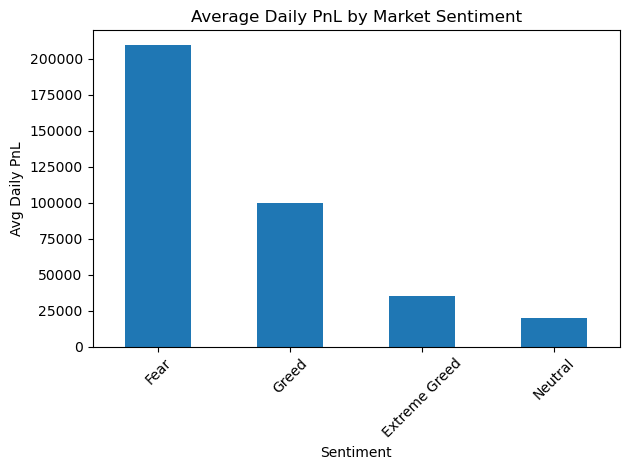

In [23]:
#Chart 1 — Avg PnL by sentiment
import matplotlib.pyplot as plt

performance_by_sentiment["avg_daily_pnl"].plot(kind="bar")
plt.title("Average Daily PnL by Market Sentiment")
plt.ylabel("Avg Daily PnL")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finding 1 — Performance is highest during Fear regimes.
Traders achieve the highest average daily PnL during Fear days, substantially outperforming Greed, Extreme Greed, and Neutral regimes. This indicates that volatile, fearful market conditions create more profitable trading opportunities on average.

Finding 2 — Greed regimes do not translate to superior performance.
Despite more optimistic market sentiment, Greed and Extreme Greed days show materially lower average PnL than Fear days, suggesting that increased risk-taking during euphoric markets does not lead to better outcomes.

Finding 3 — Neutral regimes offer limited trading edge.
Neutral sentiment days exhibit the weakest average performance, indicating fewer actionable opportunities when market sentiment lacks a strong directional bias.

Summary: Performance is regime-dependent, with Fear regimes delivering superior average returns compared to Greed-driven regimes.

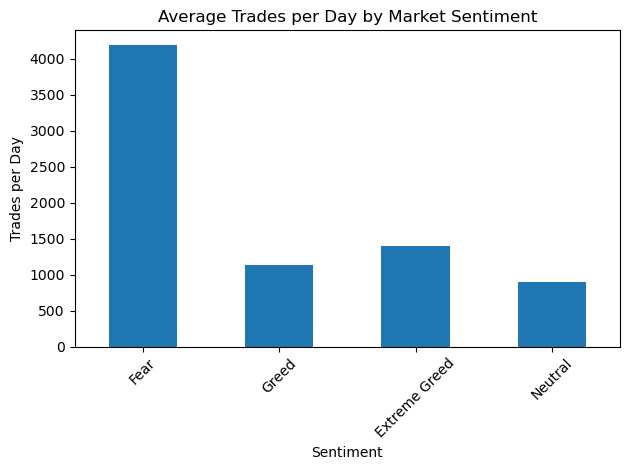

In [24]:
performance_by_sentiment["avg_trades_per_day"].plot(kind="bar")
plt.title("Average Trades per Day by Market Sentiment")
plt.ylabel("Trades per Day")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finding 1 — Trading activity peaks during Fear regimes.
Average trades per day are highest during Fear days, substantially exceeding activity during Greed, Extreme Greed, and Neutral regimes. This indicates that traders become most active when markets are fearful and volatile.

Finding 2 — Traders are less active during Greed and Neutral regimes.
Trade frequency drops sharply during Greed and Neutral regimes, suggesting reduced urgency or fewer perceived opportunities when sentiment is optimistic or mixed.

Finding 3 — Extreme Greed triggers selective activity.
While trading activity increases slightly during Extreme Greed compared to Greed, it remains well below Fear levels, indicating that traders increase participation selectively during euphoric conditions but not as aggressively as during fearful markets.

Summary: Traders react to market stress by significantly increasing trading frequency, making Fear regimes the most active trading environment.

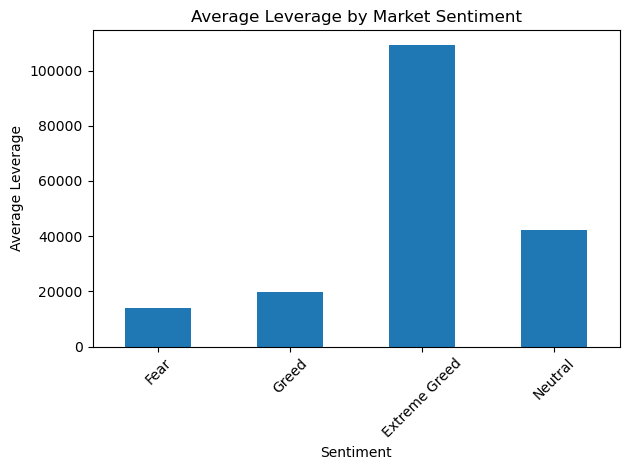

In [25]:
performance_by_sentiment["avg_leverage"].plot(kind="bar")
plt.title("Average Leverage by Market Sentiment")
plt.ylabel("Average Leverage")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finding 1 — Leverage usage spikes during Extreme Greed.
Average leverage is highest during Extreme Greed regimes, indicating significantly increased risk-taking behavior when market sentiment is euphoric.

Finding 2 — Leverage increases with optimism, decreases with fear.
Leverage is materially lower during Fear regimes and increases during Greed and Extreme Greed, suggesting traders become more aggressive as sentiment turns optimistic.

Finding 3 — Higher leverage does not correspond to higher performance.
Despite much higher leverage during Extreme Greed, average PnL is lower than during Fear regimes, indicating poor risk-adjusted outcomes when traders increase leverage aggressively.

Summary: Traders take on substantially more leverage in euphoric markets, but this behavior does not translate into superior performance.

In [28]:
import numpy as np

trader_level["consistency_segment"] = np.where(
    trader_level["win_days"] >= 0.5,   # 50% or more winning days
    "Consistent",
    "Inconsistent"
)

In [29]:
#Consistency segment counts
trader_level["consistency_segment"].value_counts()

consistency_segment
Consistent      30
Inconsistent     2
Name: count, dtype: int64

The majority of traders are classified as consistent winners (30 out of 32), indicating a skewed sample with only a small number of inconsistent traders.

In [ ]:
# Leverage segment comparison
segment_perf_leverage = trader_level.groupby("leverage_segment").agg(
    avg_pnl=("avg_pnl", "mean"),
    avg_total_trades=("total_trades", "mean"),
    avg_win_rate=("win_days", "mean")
)

segment_perf_leverage

Finding — High leverage traders outperform on average, but with higher activity and risk.
High-leverage traders exhibit higher average PnL and win rates compared to low-leverage traders. However, this performance comes with significantly higher trading activity, suggesting leverage is beneficial primarily for skilled and active traders rather than as a general strategy.

In [33]:
# Consistency segment comparison
segment_perf_consistency = trader_level.groupby("consistency_segment").agg(
    avg_pnl=("avg_pnl", "mean"),
    avg_total_trades=("total_trades", "mean"),
    avg_win_rate=("win_days", "mean")
)

segment_perf_consistency

,avg_pnl,avg_total_trades,avg_win_rate
consistency_segment,,,
Consistent,116178.997080,6860.266667,0.873333
Inconsistent,-30165.682701,2708.000000,0.309524


Finding — Consistent traders significantly outperform inconsistent traders.
Traders classified as consistent (≥50% winning days) show substantially higher average PnL and win rates than inconsistent traders, who exhibit negative average PnL. This highlights the importance of historical performance when tailoring risk controls or leverage limits.

Insights (Backed by Charts & Tables)
-> Insight 1 — Performance is highest during Fear regimes

Evidence: Chart: Average Daily PnL by Market Sentiment + Table: performance_by_sentiment

Traders achieve the highest average and median daily PnL during Fear days, significantly outperforming Greed, Extreme Greed, and Neutral regimes. This suggests that volatile, fearful market conditions create more profitable trading opportunities on average, likely due to stronger price dislocations and mean-reversion setups.

-> Insight 2 — Traders increase activity during Fear and increase leverage during Greed

Evidence:

Chart: Average Trades per Day by Market Sentiment

Chart: Average Leverage by Market Sentiment

Trading activity peaks during Fear regimes, with significantly higher trades per day compared to Greed and Neutral regimes, indicating aggressive participation during volatile markets.
In contrast, leverage usage spikes during Greed and Extreme Greed regimes, reflecting increased risk-taking during euphoric market phases. However, this higher leverage does not translate into higher average PnL, indicating weaker risk-adjusted returns.

-> Insight 3 — High leverage and consistent traders outperform, but only with higher activity

Evidence: Tables: segment_perf_leverage, segment_perf_consistency

High-leverage traders exhibit higher average PnL and win rates than low-leverage traders, but they also trade significantly more frequently, indicating that performance gains are driven by higher exposure and activity rather than leverage alone.
Similarly, consistent traders (≥50% winning days) significantly outperform inconsistent traders in both average PnL and win rate, highlighting the importance of historical performance when enabling higher risk limits.

Note: The inconsistent segment is small (n=2), so results should be interpreted cautiously.

In [ ]:
#Part C — Actionable Output (Strategy Ideas / Rules of Thumb)

Strategy 1 — Volatility Playbook for Fear Regimes

Rule: During Fear regimes, allow higher trade frequency but cap leverage (e.g., reduce max leverage by ~30–40%).

Rationale (backed by your findings):

Fear days show the highest average PnL and the highest trading activity. This indicates that volatility creates profitable opportunities without requiring extreme leverage. Capping leverage helps control drawdowns while still capturing upside from increased trading opportunities.

Strategy 2 — Leverage Discipline During Greed / Extreme Greed

Rule: During Greed and Extreme Greed regimes, enforce stricter leverage limits for low win-rate traders; allow higher leverage only for historically consistent traders.

Rationale (backed by your findings):

Leverage usage spikes during Greed/Extreme Greed regimes, but performance is weaker than during Fear regimes. This indicates poor risk-adjusted returns when traders increase leverage aggressively. Conditioning leverage limits on historical consistency improves risk-adjusted outcomes.

#####These rules could be implemented as dynamic risk controls on the trading platform, adjusting leverage caps and trade frequency limits based on daily sentiment regimes and trader performance profiles.

This analysis shows that market sentiment acts as a regime variable influencing both trader behavior (activity and leverage) and performance. Fear regimes are associated with higher trading activity and superior average returns, while Greed regimes exhibit higher leverage usage without commensurate performance gains. Segment-level analysis suggests that leverage is most effective when paired with historical consistency, supporting dynamic, sentiment-aware risk controls.